In [1]:
import networkx as nx
import numpy as np
import json
import other_predictors as op
import matplotlib.pyplot as plt
import spectralPredictor as sp
import ml_utils as ml
%matplotlib inline

{2: 0, 3: 1, 4: 2}


In [2]:
dblp_1 = json.load(open("dblp_top_1000.json","r"))

In [3]:
print dblp_1.keys()
print len(dblp_1["auths"])

[u'auths', u'names_to_num', u'year_cliques']
1000


In [4]:
yc = dblp_1["year_cliques"]

empty_years = []
for k in yc:
    if not len(yc[k]): empty_years.append(k)
for k in empty_years:
    del yc[k]

In [5]:
print [(k,len(yc[k])) for k in sorted(yc.keys()) ]

[(u'1973', 1), (u'1974', 2), (u'1975', 8), (u'1976', 8), (u'1977', 8), (u'1978', 10), (u'1979', 7), (u'1980', 12), (u'1981', 15), (u'1982', 20), (u'1983', 24), (u'1984', 20), (u'1985', 28), (u'1986', 41), (u'1987', 41), (u'1988', 63), (u'1989', 84), (u'1990', 122), (u'1991', 134), (u'1992', 170), (u'1993', 222), (u'1994', 236), (u'1995', 278), (u'1996', 318), (u'1997', 443), (u'1998', 472), (u'1999', 497), (u'2000', 603), (u'2001', 655), (u'2002', 759), (u'2003', 967), (u'2004', 1251), (u'2005', 1554), (u'2006', 1809), (u'2007', 2021), (u'2008', 2305), (u'2009', 2427), (u'2010', 2577), (u'2011', 2680), (u'2012', 2817), (u'2013', 3337), (u'2014', 3683), (u'2015', 3879), (u'2016', 1516)]


In [6]:
def add_year_to_graph(G, clique_list):
  for clique in clique_list:
    for i, el1 in enumerate(clique):
      for el2 in clique[:i]:
        G.add_edge(el1, el2)

def make_graph(startYear, stopYear, yc):
    G = nx.Graph()
    for year in sorted(yc.keys()):
      if year < stopYear and year >= startYear:
#        print year
        add_year_to_graph(G, yc[year])
    return G
 

In [7]:
train = make_graph('2006', '2010', yc)
test = make_graph('2011','2013', yc)
#print nx.info(train), nx.info(test)
print nx.is_connected(train)
biggest_comp = None
max_nodes = 0
for comp in nx.connected_component_subgraphs(train):
    nnodes = len(comp.nodes())
    if nnodes > max_nodes:
        biggest_comp = comp
        max_nodes = nnodes
print nx.is_connected(biggest_comp)

False
True


In [8]:
efRes = sp.resistancePredictor(biggest_comp)

In [9]:
efRes.validate(test, min_links=1000)

(1000, 67)

In [10]:
common = op.commonNeighbors(train)
common.validate(test,min_links=1000)

(1731, 94)

In [11]:
katz = op.katz(train)
katz.validate(test, min_links=1000)

(1000, 58)

In [13]:
ntrain, ntest = ml.format_train_test(train, test)

{30720: 0, 69634: 1, 18436: 2, 342: 3, 61442: 4, 9560: 5, 143380: 6, 8213: 7, 12311: 8, 6169: 9, 18459: 10, 20511: 11, 2081: 12, 61476: 13, 63423: 882, 3761: 759, 12332: 17, 45: 18, 17757: 600, 49200: 20, 202801: 21, 18488: 22, 132447: 601, 133183: 24, 18501: 25, 204871: 26, 30792: 27, 63566: 28, 410297: 29, 4186: 30, 2139: 31, 4189: 32, 2143: 33, 198754: 35, 6843: 36, 12389: 37, 2551: 422, 34920: 38, 202857: 39, 12394: 40, 51307: 255, 51309: 42, 69744: 43, 6262: 44, 28791: 45, 18560: 47, 120968: 48, 138: 50, 151691: 355, 28812: 52, 98446: 53, 65679: 54, 18578: 55, 61590: 56, 18584: 57, 61124: 766, 61594: 59, 120990: 60, 30879: 61, 4257: 62, 18594: 63, 20644: 64, 20646: 65, 20647: 66, 39080: 67, 18606: 69, 4272: 70, 7780: 725, 80051: 71, 301236: 72, 10423: 73, 8376: 74, 131258: 75, 53443: 77, 329664: 883, 24625: 78, 200: 79, 20397: 876, 49358: 80, 6352: 81, 131281: 82, 94418: 83, 10452: 84, 8910: 293, 8408: 86, 12324: 87, 49376: 88, 49378: 49, 60113: 295, 233: 91, 96491: 92, 2770: 296,

In [23]:
efRes = sp.resistancePredictor(ntrain)
katz = op.katz(ntrain)
common = op.commonNeighbors(ntrain)
kernels = ml.make_kernels([efRes,common,katz])


In [24]:
train_edges, train_labels = ml.select_training_edges(ntrain)
test_edges, test_labels =  ml.select_testing_edges(ntrain, ntest)
train_feats, test_feats = ml.create_features(train_edges, kernels), ml.create_features(test_edges, kernels)

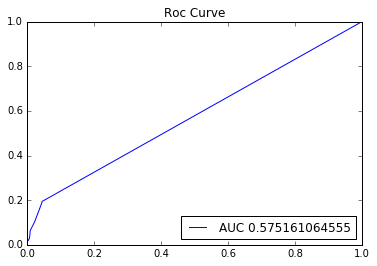

In [26]:
from sklearn.ensemble import RandomForestClassifier as rf
model = rf(n_estimators = 10, max_depth = 5)
model.fit(train_feats, train_labels)
probs = model.predict_proba(test_feats)[:,1]
ml.plot_roc_curve(test_labels, probs)

In [21]:
print min(ntest.nodes())

0
